In [88]:
import pennylane as qml
import numpy as np
from numpy.linalg import qr
from scipy.stats import rv_continuous
import matplotlib.pyplot as plt

In [2]:
## Random seed
np.random.seed( 6272 )

## Mixed state simulator
dev = qml.device( 'default.mixed', wires = 1 )

In [3]:
num_samples  = 2048

In [4]:
I = np.eye(2)
σx = np.array([[0, 1], [1, 0]])
σy = np.array([[0, -1j], [1j, 0]])
σz = np.array([[1, 0], [0, -1]])

In [5]:
def convert_to_bloch_vector(rho):
    ax = np.trace(np.dot(rho, σx)).real
    ay = np.trace(np.dot(rho, σy)).real
    az = np.trace(np.dot(rho, σz)).real
    return [ax, ay, az]

In [6]:
def plot_bloch_sphere(bloch_vectors):
    """ Helper function to plot vectors on a sphere."""
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

    ax.grid(False)
    ax.set_axis_off()
    ax.view_init(30, 45)
    # ax.dist = 7

    # Draw the axes (source: https://github.com/matplotlib/matplotlib/issues/13575)
    x, y, z = np.array([[-1.5,0,0], [0,-1.5,0], [0,0,-1.5]])
    u, v, w = np.array([[3,0,0], [0,3,0], [0,0,3]])
    ax.quiver(x, y, z, u, v, w, arrow_length_ratio=0.05, color="black", linewidth=0.5)

    ax.text(0, 0, 1.7, r"|0⟩", color="black", fontsize=16)
    ax.text(0, 0, -1.9, r"|1⟩", color="black", fontsize=16)
    ax.text(1.9, 0, 0, r"|+⟩", color="black", fontsize=16)
    ax.text(-1.7, 0, 0, r"|–⟩", color="black", fontsize=16)
    ax.text(0, 1.7, 0, r"|i+⟩", color="black", fontsize=16)
    ax.text(0,-1.9, 0, r"|i–⟩", color="black", fontsize=16)

    ax.scatter(
        bloch_vectors[:,0], bloch_vectors[:,1], bloch_vectors[:, 2], c='#e29d9e', alpha=0.3
    )

## Sine Sampler

In [7]:
class sin_prob_dist(rv_continuous):
    def _pdf(self, theta):
        return 0.5 * np.sin(theta)

In [8]:
sin_sampler = sin_prob_dist( a = 0, b = np.pi )

In [9]:
@qml.qnode(dev)
def haar_random_unitary():
    phi, omega = 2 * np.pi * np.random.uniform( size = 2 )
    theta = sin_sampler.rvs( size = 1 )
    qml.Rot( phi, theta, omega, wires = 0 )
    return qml.state()

In [151]:
def depure(mat):
    return np.array([[mat[0,0].real, mat[0, 1]], [mat[1,0], mat[1,1].real]])

In [177]:
haar_samples[0]

array([[0.26963345+3.55573468e-18j, 0.39193688-2.08126719e-01j],
       [0.39193688+2.08126719e-01j, 0.73036655-5.42463156e-19j]])

In [153]:
depure(haar_samples[4]).trace()

(1+0j)

In [11]:
haar_bloch_vectors = np.array( [ convert_to_bloch_vector( s ) for s in haar_samples ] )

In [157]:
np.dot(σx, haar_samples[4])

array([[0.21399464-2.35619935e-01j, 0.11439717+3.85584879e-20j],
       [0.88560283-1.64387086e-17j, 0.21399464+2.35619935e-01j]])

In [158]:
np.dot(haar_samples[4], σx)

array([[0.21399464+2.35619935e-01j, 0.88560283-1.64387086e-17j],
       [0.11439717+3.85584879e-20j, 0.21399464-2.35619935e-01j]])

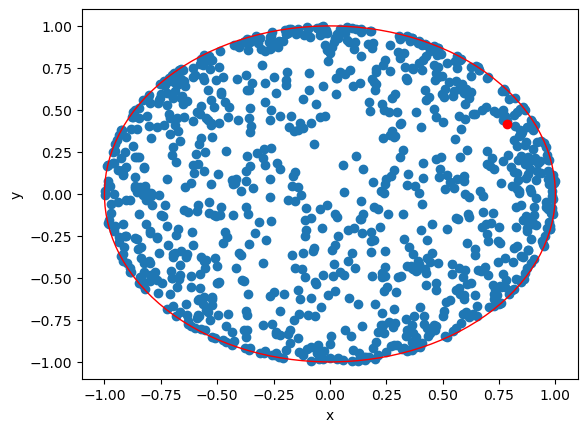

In [100]:
NSamples = 1000;
plt.scatter(haar_bloch_vectors[1:NSamples,0], haar_bloch_vectors[1:NSamples,1])
plt.scatter(haar_bloch_vectors[0, 0], haar_bloch_vectors[0,1], color='r')
plt.gca().add_patch(plt.Circle((0,0), 1, fill=False, color='r'))
plt.xlabel('x')
plt.ylabel('y')
plt.show()

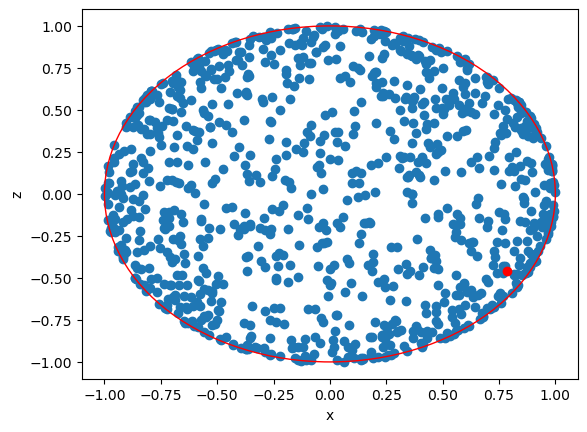

In [101]:
NSamples = 1000;
plt.scatter(haar_bloch_vectors[1:NSamples,0], haar_bloch_vectors[1:NSamples,2])
plt.scatter(haar_bloch_vectors[0, 0], haar_bloch_vectors[0, 2], color='r')
plt.gca().add_patch(plt.Circle((0,0), 1, fill=False, color='r'))
plt.xlabel('x')
plt.ylabel('z')
plt.show()

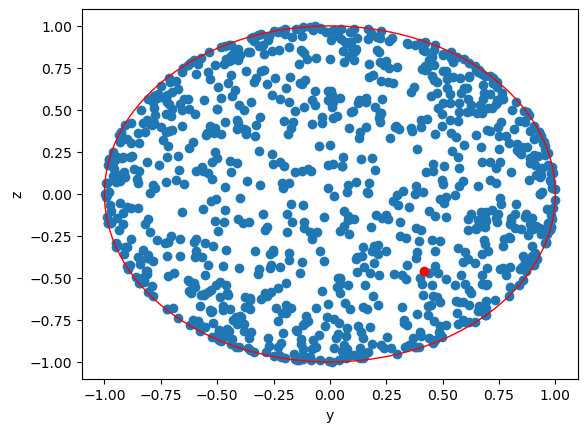

In [102]:
NSamples = 1000;
plt.scatter(haar_bloch_vectors[1:NSamples,1], haar_bloch_vectors[1:NSamples,2])
plt.scatter(haar_bloch_vectors[0, 1], haar_bloch_vectors[0, 2], color='r')
plt.gca().add_patch(plt.Circle((0,0), 1, fill=False, color='r'))
plt.xlabel('y')
plt.ylabel('z')
plt.show()

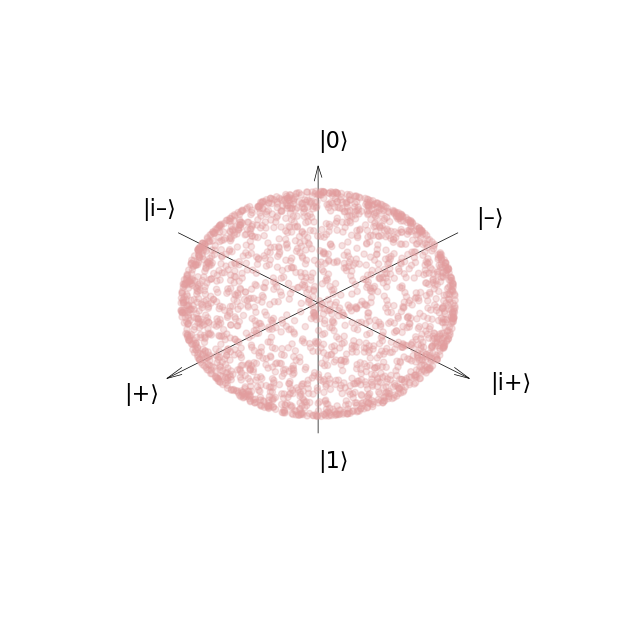

In [361]:
plot_bloch_sphere( haar_bloch_vectors )

# QR decomposition

In [257]:
def qr_haar(N):
    A, B = np.random.normal( size = ( N, N ) ), np.random.normal( size = ( N, N ) )
    Z = A + 1j * B
    
    Q, R = qr(Z)
    Lambda = np.diag( [ R[ i, i ] / np.abs( R[ i, i ] ) for i in range( N ) ] )
    
    return np.dot(Q, Lambda) 

@qml.qnode(dev)
def qr_haar_random_unitary(mat):
    # qml.QubitUnitary(qr_haar(2), wires=0)
    qml.QubitUnitary(mat, wires=0)
    return qml.state()

In [354]:
def circuit(mat):
    qml.QubitUnitary(mat, wires=0)
    return qml.state()
dev = qml.device("default.qubit", wires=1)
qnode = qml.QNode(circuit, dev)

In [358]:
qr_haar_random_unitary(X)

array([[ 0.24508246-3.15807907e-18j, -0.34465255-2.57355135e-01j],
       [-0.34465255+2.57355135e-01j,  0.75491754+5.66543816e-18j]])

In [360]:
X.dot(X.conj().T)

array([[ 1.000000e+00-7.06464075e-18j, -1.516364e-16-2.24856790e-16j],
       [-1.516364e-16+2.09058078e-16j,  1.000000e+00+9.48608846e-18j]])

In [342]:
A1 = qr_haar_random_unitary(X)
A1

array([[ 0.24508246-3.15807907e-18j, -0.34465255-2.57355135e-01j],
       [-0.34465255+2.57355135e-01j,  0.75491754+5.66543816e-18j]])

In [343]:
qml.state().data

[]

In [ ]:
qml.Measure

In [323]:
X = qr_haar(2)
X

array([[-0.42623182+0.25181122j,  0.85855119+0.13344433j],
       [ 0.33497694-0.80169071j,  0.43745763-0.23176124j]])

In [329]:
X.dot(X.conj().T)/X.dot(X.conj().T).trace().real

array([[ 5.00000e-01-3.53232038e-18j, -7.58182e-17-1.12428395e-16j],
       [-7.58182e-17+1.04529039e-16j,  5.00000e-01+4.74304423e-18j]])

In [339]:
qr_haar_random_unitary(X)

array([[ 0.24508246-3.15807907e-18j, -0.34465255-2.57355135e-01j],
       [-0.34465255+2.57355135e-01j,  0.75491754+5.66543816e-18j]])

In [322]:
X.dot(X.conj().T)/np.trace(X.dot(X.conj().T))

array([[5.00000000e-01+2.59464205e-20j, 1.00427805e-17+3.35608518e-18j],
       [1.00427805e-17-9.41952481e-18j, 5.00000000e-01-2.59464205e-20j]])

In [260]:
from scipy import *

In [306]:
N = 2
Z = 1/np.sqrt(2) * (np.random.normal( size = ( N, N ) ) + 1j * np.random.normal( size = ( N, N ) ))
Z

array([[ 0.31090294-0.56610819j,  0.55931868+0.10142171j],
       [ 0.97180409-0.25480172j, -0.07884967-0.64634673j]])

In [308]:
Q, R = qr(Z)
Q.dot(R)

array([[ 0.31090294-0.56610819j,  0.55931868+0.10142171j],
       [ 0.97180409-0.25480172j, -0.07884967-0.64634673j]])

In [311]:
R

array([[-1.19434761+0.j        , -0.17125834+0.25122186j],
       [ 0.        +0.j        ,  0.80911264+0.j        ]])

In [309]:
Lambda = np.diag([R[i, i]/ abs(R[i,i]) for i in range(N)])

In [315]:
Q.dot(Lambda).dot(Q)

array([[-0.54586884+0.16449982j,  0.3434006 -0.74635316j],
       [ 0.16173367+0.80548695j,  0.49311575+0.28612906j]])

In [305]:
np.dot(np.dot(Q, R), R)

array([[-0.45704231+0.68232103j,  0.02009141+1.35938186j],
       [ 1.04428338-0.01934171j,  0.71700654-0.17773845j]])

In [255]:
X.dot(X.conj().T)

array([[ 0.57208493+5.14421010e-18j, -0.19269188-4.55712193e-01j],
       [-0.19269188+4.55712193e-01j,  0.42791507-5.14421010e-18j]])

In [242]:
QF2 = np.matrix(QF) * np.matrix(QF).H
print(QF2)

[[ 1.0000000e+00-1.23515542e-17j -9.7625591e-17-6.23109836e-17j]
 [-9.7625591e-17+6.43698743e-17j  1.0000000e+00+3.02654587e-18j]]


In [240]:
qr_haar_random_unitary(QF)

array([[ 0.00906861-1.60541226e-19j, -0.08486179-4.22475066e-02j],
       [-0.08486179+4.22475066e-02j,  0.99093139+2.79508521e-18j]])

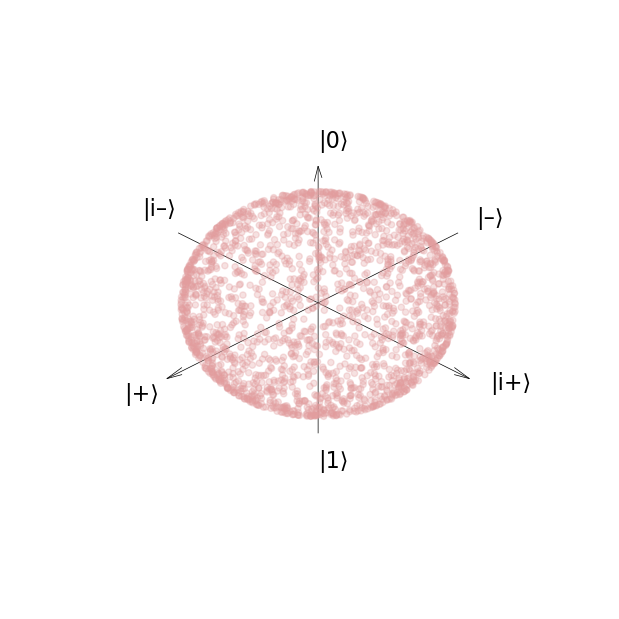

In [161]:
qr_haar_samples = [ qr_haar_random_unitary() for _ in range( num_samples ) ]
qr_haar_bloch_vectors = np.array( [convert_to_bloch_vector(s) for s in qr_haar_samples ] )
plot_bloch_sphere(qr_haar_bloch_vectors)

In [163]:
qr_haar_samples[0]

array([[ 0.50625168-1.10551378e-17j, -0.11498647-4.86558350e-01j],
       [-0.11498647+4.86558350e-01j,  0.49374832+4.39461111e-18j]])

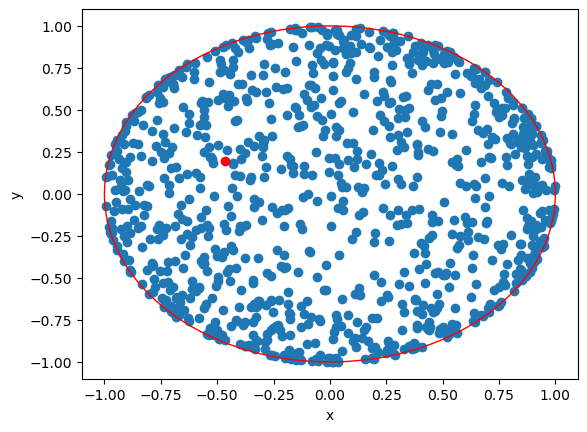

In [103]:
NSamples = 1000;
plt.scatter(qr_haar_bloch_vectors[1:NSamples,0], qr_haar_bloch_vectors[1:NSamples,1])
plt.scatter(qr_haar_bloch_vectors[0, 0], qr_haar_bloch_vectors[0, 1], color='r')
plt.gca().add_patch(plt.Circle((0,0), 1, fill=False, color='r'))
plt.xlabel('x')
plt.ylabel('y')
plt.show()

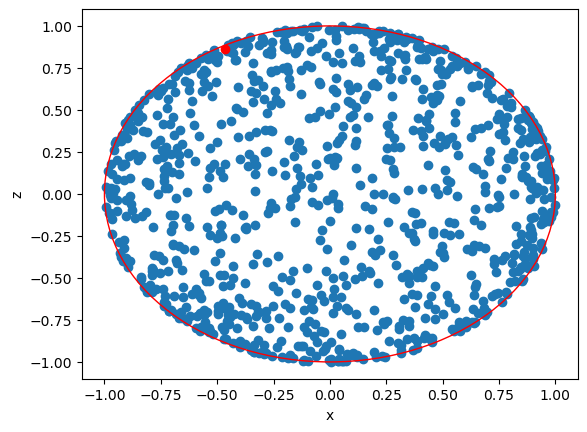

In [104]:
NSamples = 1000;
plt.scatter(qr_haar_bloch_vectors[1:NSamples,0], qr_haar_bloch_vectors[1:NSamples,2])
plt.scatter(qr_haar_bloch_vectors[0, 0], qr_haar_bloch_vectors[0, 2], color='r')
plt.gca().add_patch(plt.Circle((0,0), 1, fill=False, color='r'))
plt.xlabel('x')
plt.ylabel('z')
plt.show()

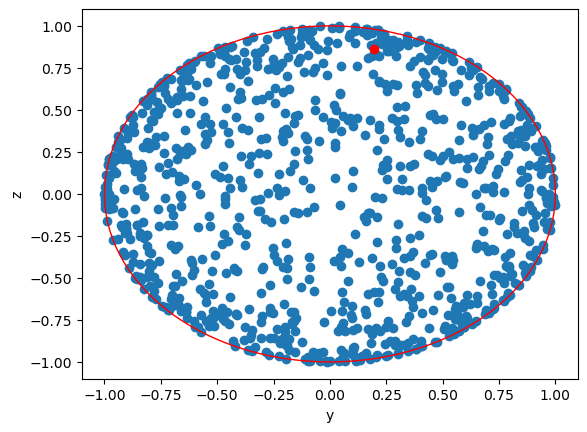

In [105]:
NSamples = 1000;
plt.scatter(qr_haar_bloch_vectors[1:NSamples,1], qr_haar_bloch_vectors[1:NSamples,2])
plt.scatter(qr_haar_bloch_vectors[0, 1], qr_haar_bloch_vectors[0, 2], color='r')
plt.gca().add_patch(plt.Circle((0,0), 1, fill=False, color='r'))
plt.xlabel('y')
plt.ylabel('z')
plt.show()